# 2. Bike Sharing: Predicción de Demanda Horaria


El objetivo de este ejercicio es predecir la demanda de arriendos de bicicletas en el programa Capital Bikeshare en Washington, D.C. Tenemos como misión entrenar un modelo para obtener un puntaje correspondiente al top-100 del "leaderboard" final, lo que implica un valor superior o igual a  0.37748 . La función utilizada para evaluar este concurso está dada por :

$$ E_{bikes}(y,\hat{y}) = \sqrt{\frac{1}{n}\sum_{i}(ln(y_i + 1) - ln( \hat{y} _i + 1 ))^2} $$

Donde,

$n:$ Número de horas en el conjunto de test (ejemplos)

$\hat{y}_i :$ Predicción de count

$y_i :$ Valor real de count



### a) Carga de dataset y descripción
Para ver de que variables está compuesto el dataset, cargamos los datos desde los archivos csv, mostramos la cantidad de datos, su tipo y una pequeña descripción (valores máximos, mínimos, media, entre otros). Se agrega una nueva columna de hora, derivada de la columna tiempo.

In [2]:
# Muestra de como son los datos
import pandas as pd
dftrain = pd.read_csv('bike_sharing_train.csv')
print(dftrain[0:10])

   Unnamed: 0             datetime  season  holiday  workingday  weather  \
0           3  2011-01-01 03:00:00       1        0           0        1   
1           4  2011-01-01 04:00:00       1        0           0        1   
2           5  2011-01-01 05:00:00       1        0           0        2   
3           6  2011-01-01 06:00:00       1        0           0        1   
4           7  2011-01-01 07:00:00       1        0           0        1   
5           9  2011-01-01 09:00:00       1        0           0        1   
6          14  2011-01-01 14:00:00       1        0           0        2   
7          16  2011-01-01 16:00:00       1        0           0        2   
8          17  2011-01-01 17:00:00       1        0           0        2   
9          18  2011-01-01 18:00:00       1        0           0        3   

    temp   atemp  humidity  windspeed  casual  registered  count  
0   9.84  14.395        75     0.0000       3          10     13  
1   9.84  14.395        75   

In [3]:

import numpy as np
import matplotlib.pyplot as plt

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print("Cantidad datos, DataType")
print(df.info())
print("\nSummary - dataframe completo:\n")
print(df.describe())
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])
print("\n----------\nCantidad de datos set entrenamiendo: ",ntrain)
print("Cantidad de datos testing: ", len(dftest))
print("Cantidad de datos validación: ",len(dfval))
print("Datos totales: ",nval+len(dftest))

#Para ver el número de valores distintos
print([len(set(df.datetime)),len(set(df.season)),len(set(df.holiday)),len(set(df.workingday))])
print([len(set(df.weather)),len(set(df.temp)),len(set(df.atemp)),len(set(df.humidity)),len(set(df.windspeed))])
print([len(set(df.casual)),len(set(df.registered)),len(set(df.hour))])#,len(set(df.countt))])


Cantidad datos, DataType
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 2146
Data columns (total 13 columns):
Unnamed: 0    10886 non-null int64
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(9), object(1)
memory usage: 1.2+ MB
None

Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.

Los datos están divididos en tres set de datos, un de entrenamiento, validación y testing, con 6562, 2147 y 2177 datos respectivamente. La cantidad de datos totales es de 10.886. 

A continuación se procede a describir las variables del problema, su descripción, tipo y los valores diferentes que hay de cada una.

Variable | Descripción | Tipo | Valores diferentes
--- | --- | --- | ---
**Datetime** | Hora y marca temporal | String | 10886 
**Season**| Estación del año | Int | 4 (1,2,3,4)
**Holiday** | Si el día es considerado vacaciones | Bool | 2
**Workingday** | Si el día no es ni fin de semana ni vacaciones| Bool | 2
**Weather** | Clima | Int | 4 (1,2,3,4)
**Temp** | Temperatura en celsius | Float | 49
**Atemp** | Sensación térmica en celsius | Float | 60
**Humidity** | Humedad relativa | Float | 89
**Windspeed** | Velocidad del viento | Float | 28
**Casual** | Número de rentas de usuarios no registrados iniciadas | Int | 309
**Registered** |Número de rentas de usuarios registrados iniciadas  | Int | 731
**Count** | Número de rentas totales | Int | 822
**Hour** | Hora del día | Int | 24

Los datos son bien diversos, habiendo variables que pueden tomar un menor rango de valores discretos, pero cada uno depende de la naturaleza del atributo. La distribución de estos, que se puede observar en los siguientes gráficos, no es igual en ninguno de los casos, excepto, son similares con count, casual y registered, puesto que la primera es la suma de los dos siguientes.


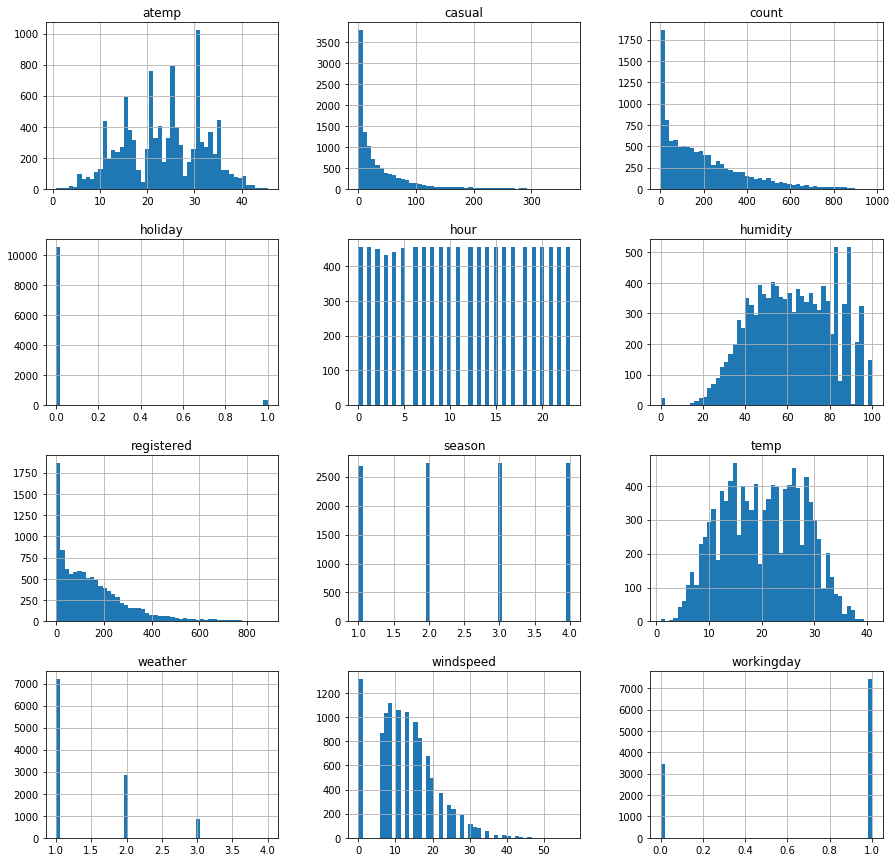

In [11]:
df.ix[:,1:].hist(figsize=(15, 15), bins=50)
plt.show()

Se puede observar también que en la variable atemp, hay una gran cantidad de elementos con temperatura aproximada a 30 grados con lo que se puede deducir que fue un año con buen clima para arrendar bicicletas.
Tanto en registered y casual, empieza con un valor muy alto de ocurrencia para 0 bicicletas arrendadas, esto quiere decir que la mayoría de la gente que arrienda bicicletas ahí es por un paseo fortuito en la ciudad de Washington. En registered esto se visualiza menos dado que la cola es más densa que en casual.


### b) Árbol de regresión

Para entrenar el árbol de regresión, se utilizan las siguientes variables del modelo: *season*, *holiday*, *workingday*, *weather*, *temp*, *atemp*, *humidity*, *windspeed* y *hour*, debido que son variables númericas tratables en un entrenamiento. En el caso de *datetime* no se puede ocupar pues corresponde a un string, no obstante se ocupa su transformación que es *hour*. *Count* tampoco se ocupa por ser la variable objetivo, y *casual* y *registered* por ser parte de élla.

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


SCORE TEST=0.703388
KAGG EVAL TRAIN = 0.028516
KAGG EVAL VALIDATION = 0.554511
KAGG EVAL TEST = 0.574239


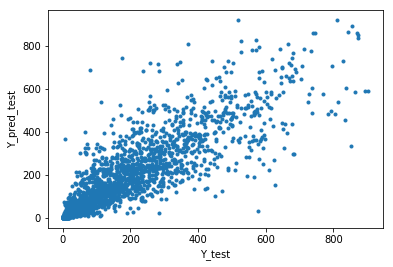

In [5]:
from sklearn.tree import DecisionTreeRegressor as Tree

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour']]
Ydf = df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TRAIN = %f"%kagg_train)
print("KAGG EVAL VALIDATION = %f"%kagg_val)
print("KAGG EVAL TEST = %f"%kagg_test)
plt.plot(Y_test,Y_pred_test,'.')
plt.xlabel("Y_test")
plt.ylabel("Y_pred_test")
plt.show()

El gráfico ideal de Y_test vs Y_pred_test sería una función del tipo $y=x$ , claramento esto no se visualiza dado que eso implicaría que el modelo es perfecto, pero sí se observa una aproximación a eso en el rango [0,400], luego de esto los valores de count están muy dispersos respecto a esta asíntota.

El error de testing dice que el árbol está muy sobre ajustado, dado que se obtiene  un error con el training set de 0.028 y luego  0.554511 con el set de validación. Dado estos resultados es de suma importancia no utilizar todos los parámetros de la función con sus valores por defecto, pues se puede producir estas situaciones en las que se tiene modelo muy ajustados hacia una u otra parte de los datos. Esto se soluciona explorando los posibles valores que disminuyen estos errores, y realizando distintas configuraciones de los hiper-parámetros e ir experimentando las nuevas métricas hasta quedarse con el mejor.

### c) Mejora de árbol de regresión

Para mejorar el árbol de regresión previamente definido se  realizaron cambios en los hiper-parámetros del modelo para apuntar a un error menor. Para esto se variarán las siguientes propiedades:

+ Máxima profundidad (Max depth)
+ Cantidad mínima de elementos para separar un nodo interno (Min samples split)
+ Mínima cantidad de elementos para ser considerado hoja (Min samples leaf)
+ Cantidad máxima de nodos hoja (Max leaf node)

Aplicando estos cambios a los parámetros se disminuirá el grado de sobre-ajuste, pues sin modificarlos (dejando los que vienen por default) se generan modelos más generales que no incluyen reglas que podrían separar de mejor manera los datos. En el caso de cantidad mínima de elemenos para separar un nodo y cantidad de elementos para ser considerados nodos hojas, mientras estos valores sean más pequeños más general será el árbol obteniendo un modelo sobre-ajustado. Cuando estos parámetros toman valores grandes, habrán menos reglas.

Para validar los cambios, se utilizó el set de validación.

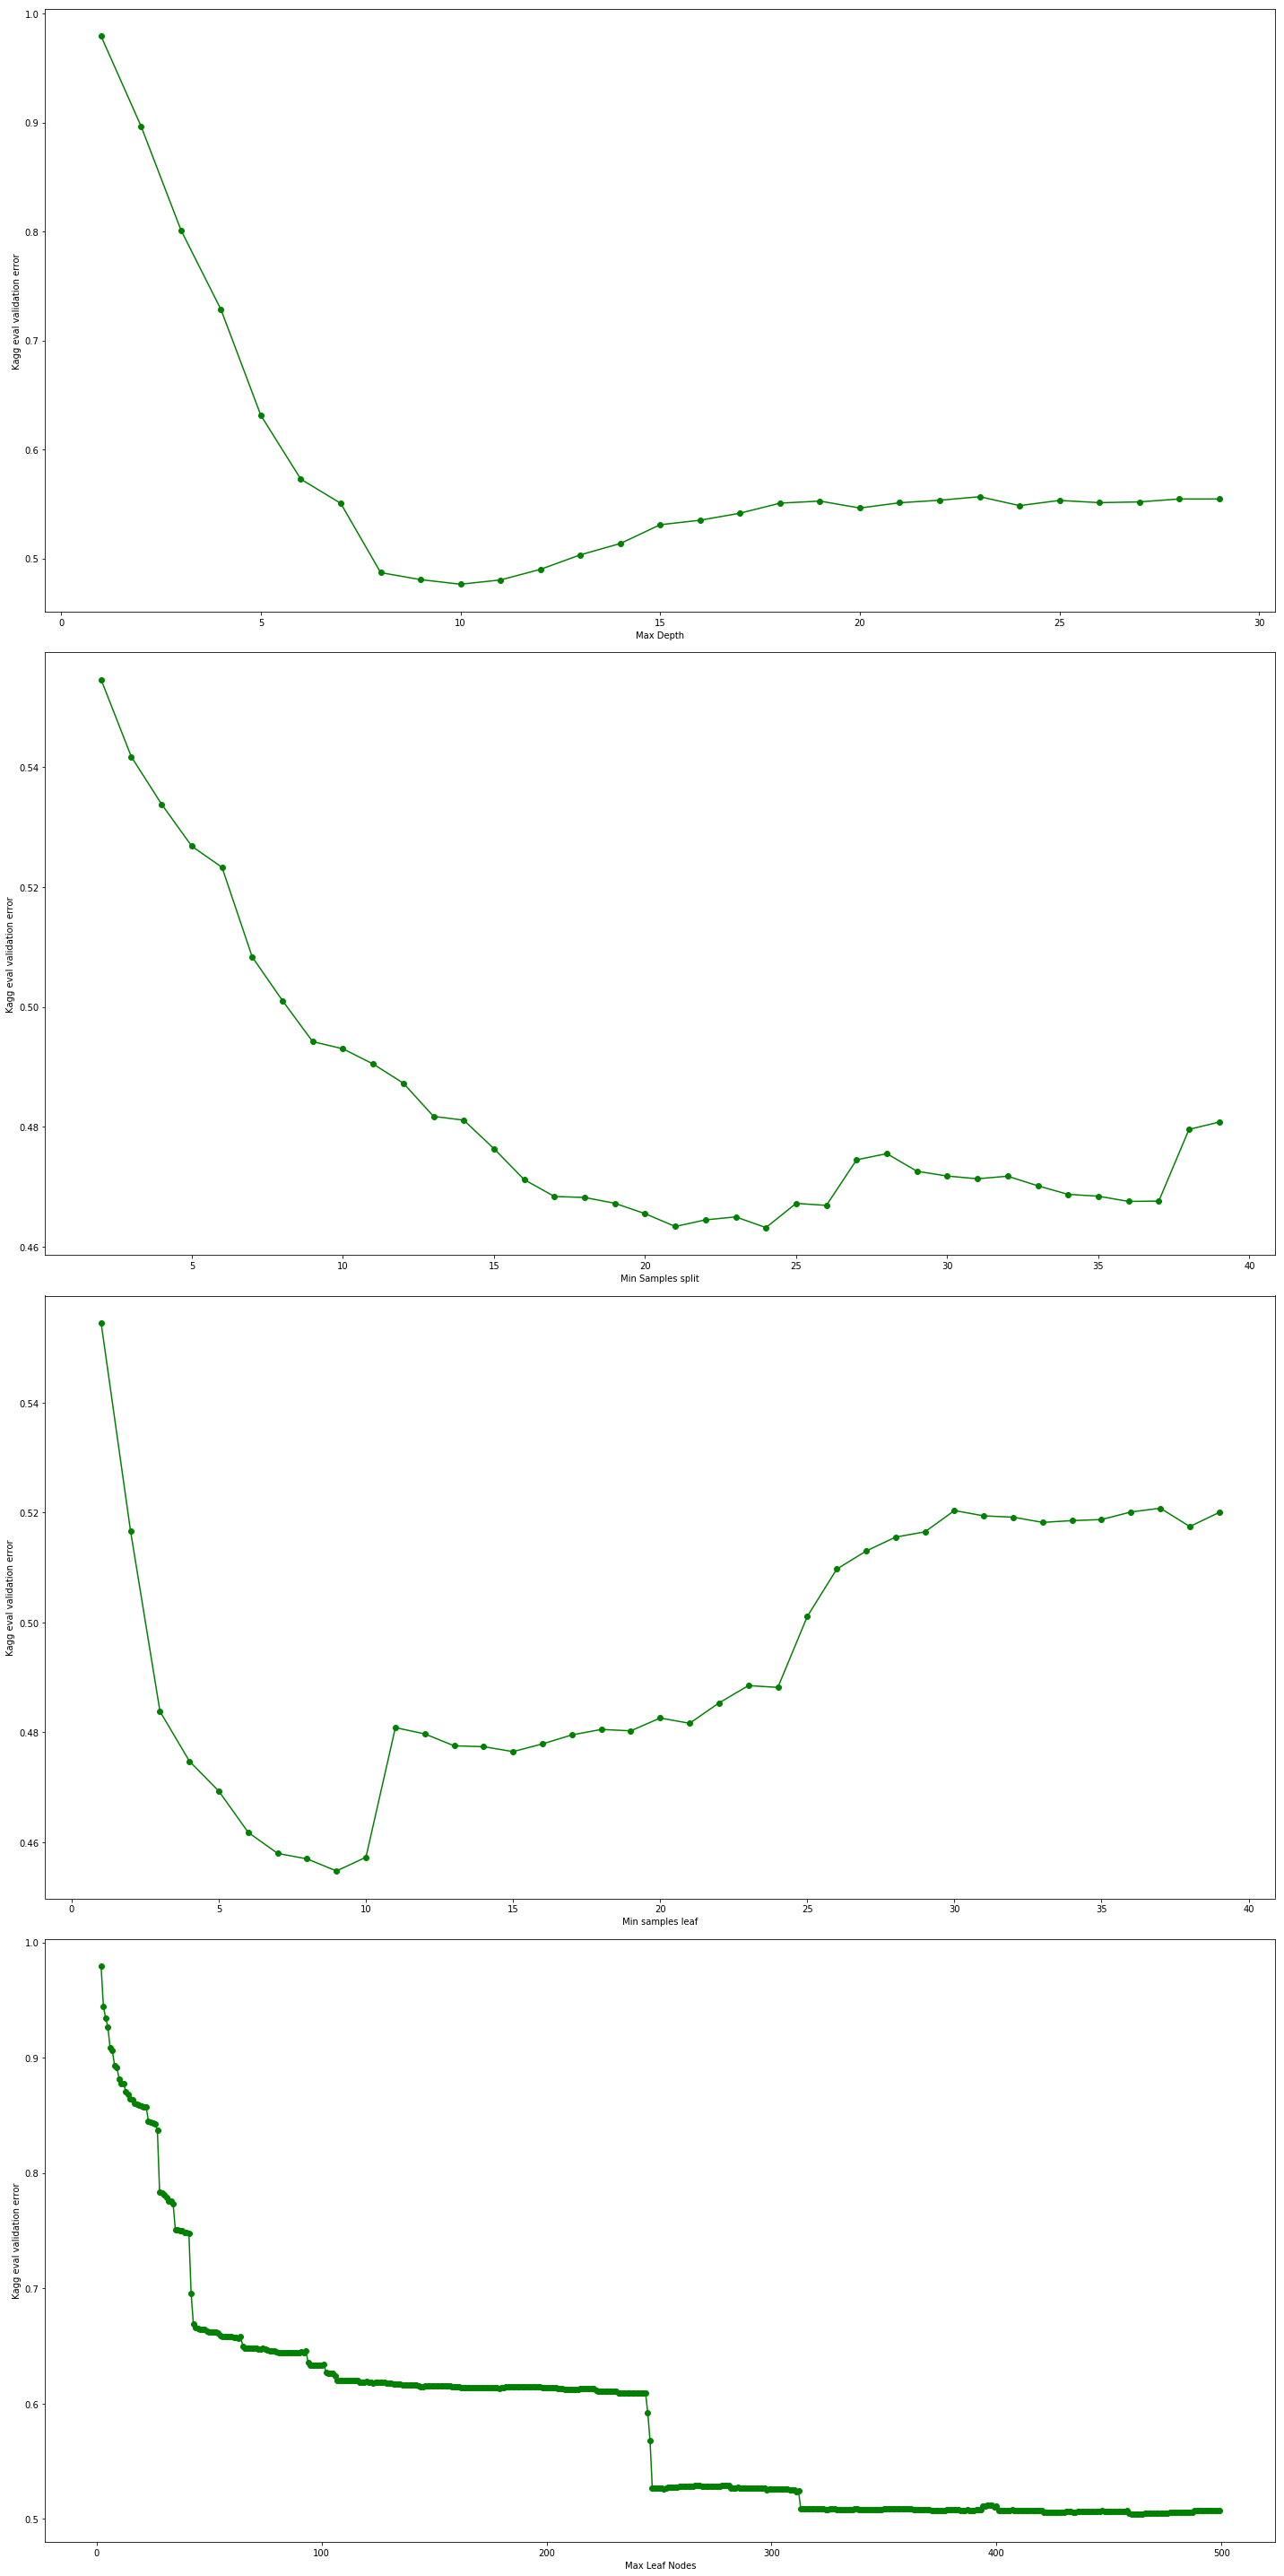

KAGG VAL = 0.476274 , Max Depth = 10
KAGG VAL = 0.463227 , Min Samples Split = 24
KAGG VAL = 0.454764 , Min Samples Leaf = 9
KAGG VAL = 0.503918 , Max Leaf Nodes = 461
KAGG EVAL TEST = 0.490340, with Min Samples Leaf=9 


In [27]:
minor_errors = []
kagg_values = []

##Variando Max Depth 

plt.figure(figsize=(20,40))
for i in range(1,30):
    model = Tree(random_state=0,max_depth=i)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kagg_values.append(kagg_val)

index = kagg_values.index(min(kagg_values))
minor_errors.append([index+1,min(kagg_values)])
plt.subplot(4,1, 1)
plt.plot(range(1,30),kagg_values,'go-')
plt.xlabel("Max Depth")
plt.ylabel("Kagg eval validation error")


## Variando min_samples_split 
kagg_values = []
for i in range(2,40):
    model = Tree(random_state=0,min_samples_split=i)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kagg_values.append(kagg_val)

index = kagg_values.index(min(kagg_values))
minor_errors.append([index+2,min(kagg_values)])  
plt.subplot(4,1, 2)
plt.plot(range(2,40),kagg_values,'go-')
plt.xlabel("Min Samples split")
plt.ylabel("Kagg eval validation error")


### Variando Min_samples_leaf
kagg_values = []
for i in range(1,40):
    model = Tree(random_state=0,min_samples_leaf=i)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kagg_values.append(kagg_val)
    
index = kagg_values.index(min(kagg_values))
minor_errors.append([index+1,min(kagg_values)])
plt.subplot(4,1, 3)
plt.plot(range(1,40),kagg_values,'go-')
plt.xlabel("Min samples leaf")
plt.ylabel("Kagg eval validation error")


### Variando Max_leaf_nodes
kagg_values = []
for i in range(2,500):
    model = Tree(random_state=0,max_leaf_nodes=i)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val)
    kagg_values.append(kagg_val)

index = kagg_values.index(min(kagg_values))
minor_errors.append([index+2,min(kagg_values)])
plt.subplot(4,1,4)
plt.plot(range(2,500),kagg_values,'go-')
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Kagg eval validation error")
plt.tight_layout()#(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

print("KAGG VAL = %f , Max Depth = %d"%(minor_errors[0][1],minor_errors[0][0]))
print("KAGG VAL = %f , Min Samples Split = %d"%(minor_errors[1][1],minor_errors[1][0]))
print("KAGG VAL = %f , Min Samples Leaf = %d"%(minor_errors[2][1],minor_errors[2][0]))
print("KAGG VAL = %f , Max Leaf Nodes = %d"%(minor_errors[3][1],minor_errors[3][0]))

model = Tree(random_state=0,min_samples_leaf=9)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_val = eval_bikemodel(Y_pred_test,Y_test)
print("KAGG EVAL TEST = %f, with Min Samples Leaf=9 "%kagg_val)

En cada caso se varió sólamente un hiper parámetro, dejando el resto por defecto. Luego se gráficó su comportamiento en un rango de valores. En el caso de max_depth se ejecutó en un rango de 30 valores dado que desde profundidad máxima de 28 en adelante el valor de evaluación era el mismo.

Con los nuevos parámetros se logró una gran reducción el KAGG error de validación, de 0.554511 a 0.454764 en el caso de considerar Min Samples leaf igual a 9. Para los tres casos restantes también se disminuyó el error. Se fue experimentando distintos árboles, utilizando todas las combinaciones posibles entre estas 4 propiedades. Como resultado, se volvió a crear otro modelo cuyo error de validación es de 0.490340, siendo menor que 0.574239 para la configuración sin hiper parámetros.

Ajustando los valores se logra disminuir el sobre-ajuste del modelo a los datos de entrenamiento.

### d) Segunda mejora Árbol regresión
Como la variable *count*, que es la variable respuesta al problema, está sesgada hacia la izquierda hay que aplicar alguna transformación para cambiar su distribución a una normal (normalización).


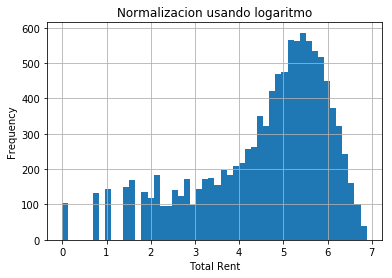

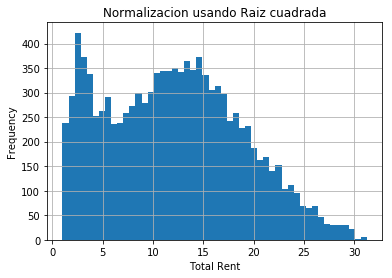

In [28]:
np.log(df.ix[:,['count']]).hist(bins=50)
plt.xlabel("Total Rent")
plt.ylabel("Frequency")
plt.title("Normalizacion usando logaritmo")
plt.show()
np.sqrt(df.ix[:,['count']]).hist(bins=50)
plt.xlabel("Total Rent")
plt.ylabel("Frequency")
plt.title("Normalizacion usando Raiz cuadrada")
plt.show()

Al aplicar logaritmo y raíz cuadrada se logra normalizar los datos respecto a su representación original que estaba muy sesgada hacia la izquierda. No obstante, si bien se ve que los datos están más repartidos, el logaritmo igual tiene un sesgo, en este caso, hacia la izquierda, y la raiz un leve corrimiento a la izquierda. No obstante, se esperan mejores resultados que sin normalizar el atributo objetivo *count*. Así, se decidirá trabajar con logaritmo esperando obtener mejores resultados que con raiz cuadrada.

Para aumentar el análisis del árbol regresor se ha agregado como nuevos atributos el día, mes y año de la renta de bicicleta, esperando a tener mejores resultados dado que hay patrones que se pueden idenficiar en ciertas fechas, y fenómenos que hacen variar la renta año a año. Por comodidad de código, solo se dejó el código agregando día-mes-año, mostrando más adelante la comparación de los score obtenidos si se agregase día-año.



In [43]:
# Add day-month-year
df['cday'] = pd.to_datetime(df['datetime']).dt.dayofweek#0:lunes,6:domingo
df['cday'] = pd.to_numeric(df['cday'])
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['month'] = pd.to_numeric(df['month'])
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['year'] = pd.to_numeric(df['year'])
Xdf_date = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]

# Usando Xdf original con logaritmo
Ydf = np.log(df.ix[:,'count'])
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0,min_samples_leaf=9)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("Con logaritmo - sin fecha agregada")
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(np.exp(Y_pred_train),np.exp(Y_train))
kagg_val = eval_bikemodel(np.exp(Y_pred_val),np.exp(Y_val))
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print("KAGG EVAL TRAIN = %f"%kagg_train)
print("KAGG EVAL VAL = %f"%kagg_val)
print("KAGG EVAL TEST = %f"%kagg_test)

# Usando logaritmo con fecha completa
X_train = Xdf_date[0:ntrain].values
X_val = Xdf_date[ntrain:nval].values
X_test = Xdf_date[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0,min_samples_leaf=9)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print("\nCon logaritmo - con fecha agregada (dia,mes,anno)")
print("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(np.exp(Y_pred_train),np.exp(Y_train))
kagg_val = eval_bikemodel(np.exp(Y_pred_val),np.exp(Y_val))
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print ("KAGG EVAL TRAIN = %f"%kagg_train)
print ("KAGG EVAL VAL = %f"%kagg_val)
print ("KAGG EVAL TEST = %f"%kagg_test)

Con logaritmo - sin fecha agregada
SCORE TEST=0.870667
KAGG EVAL TRAIN = 0.376300
KAGG EVAL VAL = 0.459266
KAGG EVAL TEST = 0.497257

Con logaritmo - con fecha agregada (dia,mes,anno)
SCORE TEST=0.902754
KAGG EVAL TRAIN = 0.309683
KAGG EVAL VAL = 0.386555
KAGG EVAL TEST = 0.427368




| SCORE      | Sin fecha | Día-Año | Día-Mes-Año |  
| ---        | ---:     | ---:         | ---:     | 
| SCORE TEST | 0.872298 | 0.898865 | 0.902798 |  
|KAGG EVAL TRAIN | 0.383031 | 0.325206 | 0.322202 |  
|KAGG EVAL VAL | 0.455523 | 0.384123 | 0.385187 | 
|KAGG EVAL TEST | 0.494029 | 0.436318 | 0.427912 | 

Con la adición de la fecha por separado, día-més-año, se tiene nuevo error de pruebas de 0.427912, menor que el generado sin esta información. Cabe destacar que también se produce una mejora en el modelo solamente al aplicar una normalización de los datos, en este caso logaritmo.

La inclusión de la tripleta Día-Mes-Año tuvo mejoras tanto en el score del test, error del training set y evaluation set, no así con el de validation, por aproximadamente 0.1%.

### e) SVM no lineal

En esta sección se entrenará una svm no lineal para resolver el problema. La representación a utilizar es la determinada anteriormente, a la cual se le agregó una columna de día, mes y año. No se modificarán los hiper-parámetros, dejando ese estudio para el siguiente punto. Se realiza un escalamiento de los datos para mejorar el rendimiento del método.

In [46]:
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday','month','year'])
Ydf = np.log(df.ix[:,'count'])

X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.transform(X_test)

from sklearn.svm import SVR #Default kernel RBF / Epsilon-Support Vector Regression.
model = SVR()
model.fit(X_train,Y_train)
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
# evaluacion
kagg_train = eval_bikemodel(np.exp(Y_pred_train),np.exp(Y_train))
kagg_val = eval_bikemodel(np.exp(Y_pred_val),np.exp(Y_val))
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print("KAGG EVAL TRAIN = %f"%kagg_train)
print("KAGG EVAL VAL   = %f"%kagg_val)
print("KAGG EVAL TEST  = %f"%kagg_test)

KAGG EVAL TRAIN = 0.220828
KAGG EVAL VAL   = 0.292625
KAGG EVAL TEST  = 0.326723


SVM lineal, sin seteo de parámetros, tiene un resultado muy superior al caso del árbol de regresión sin modificación, logrando un error de test de 0.326723, y errores de entrenamiento y evalución menor. Por lo tanto, para este problema, una svm tiene mejor rendimiento generando modelos que un árbol de regresión. Una característica del problema que influye en este resultado es que es altamente no lineal, por lo que un método no lineal se ajusta de sobremanera.


# f) SVM mejorada

Buscando mejorar los resultados anteriores, y al igual que en la sección de árbol de regresión, se modificarán los hiper-parámetros para explorar el espacio de soluciones en miras de encontrar una mejor solución con errores menores. Se variarán los parámetros de kernel, epsilon y el penalizador c. 

In [49]:
Cs = [1.0,1.2,1.4,1.6,1.8,2.0]
eps = [0.01,0.05,0.1]
kernels = ['linear','poly','rbf']

for k in kernels:
    print("- Kernel: ",k)
    for c in Cs:
        for e in eps:
            model = SVR(C = c, epsilon = e, kernel = k)
            model.fit(X_train,Y_train)
            Y_pred_val = model.predict(X_val)
            kagg_val = eval_bikemodel(np.exp(Y_pred_val),np.exp(Y_val))
            print("KAGG EVAL VAL = %f , C = %f , e = %f "%(kagg_val,c,e))
        print("--------------------")

- Kernel:  linear
KAGG EVAL VAL = 0.606930 , C = 1.000000 , e = 0.010000 
KAGG EVAL VAL = 0.607050 , C = 1.000000 , e = 0.050000 
KAGG EVAL VAL = 0.603517 , C = 1.000000 , e = 0.100000 
--------------------
KAGG EVAL VAL = 0.606941 , C = 1.200000 , e = 0.010000 
KAGG EVAL VAL = 0.607045 , C = 1.200000 , e = 0.050000 
KAGG EVAL VAL = 0.603500 , C = 1.200000 , e = 0.100000 
--------------------
KAGG EVAL VAL = 0.606964 , C = 1.400000 , e = 0.010000 
KAGG EVAL VAL = 0.607054 , C = 1.400000 , e = 0.050000 
KAGG EVAL VAL = 0.603501 , C = 1.400000 , e = 0.100000 
--------------------
KAGG EVAL VAL = 0.606951 , C = 1.600000 , e = 0.010000 
KAGG EVAL VAL = 0.607062 , C = 1.600000 , e = 0.050000 
KAGG EVAL VAL = 0.603504 , C = 1.600000 , e = 0.100000 
--------------------
KAGG EVAL VAL = 0.606918 , C = 1.800000 , e = 0.010000 
KAGG EVAL VAL = 0.607050 , C = 1.800000 , e = 0.050000 
KAGG EVAL VAL = 0.603533 , C = 1.800000 , e = 0.100000 
--------------------
KAGG EVAL VAL = 0.606942 , C = 2.0000

Luego de que el proceso se tomara su tiempo para ejecutar las svm con diferentes parámetros, se obtuvo como resultado que la configuración de Kernel rbf (Radial basis function kernel), con parámetro de penalización C = 1.8 y un Epsilon = 0.05, el error de evaluación es el mínimo, igual a 0.288044.

En relación a los kernel, linear tiene a entregar modelos con un elevado error, cercano al 60%. Poly es bastante menor pero rbf esta por debajo de éste.

El valor KAGG en el set de pruebas, para los parámetros óptimos, es de 0.323642, con una mejora de 0.3% aproximadamente.


In [51]:
model = SVR(C=1.8 , epsilon=0.05, kernel="rbf")
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print("KAGG EVAL TEST = %f"%kagg_test)

KAGG EVAL TEST = 0.323642


Un modelo con los parámetros óptimos tiene un error de Test de 0.323642, disminuyendo en 0.3% respecto al error de test con una svm con parámetros por defecto. Como se mencionó antes, el kernel rbf tiene un mejor desempeño, seguido del polinomial, y por último el lineal. Esta relación se responde con la naturaleza no lineal del problema.

Para cada iteración, los mejores resultados se encontraron con epsilon 0.5.

# g) Cross validation

En esta sección se evaluará el efecto de utilizar el dataset de validación, sumado al de entrenamiento, para seleccionar los mejores parámetros estructurales, tanto para el árbol de clasificación como para la SVM mediante validación cruzada. Se espera que, al aumentar el tamaño del dataset, se genere un mejor modelo para ambas técnicas.

Para el árbol se varió los parámetros min_samples_leaf y min_samples_split dentro de un rango que contiene sus valores óptimos anteriormente encontrados. 

Para la SVM se mantuvo el valor de epsilon = 0.05 y de kernel rbf por tener resultados sobresalientes respecto a los otros valores que podían tomar. El parámetro de penalización C se varió dentro de los mismos valores.


In [52]:
from sklearn import cross_validation

Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Ydf = np.log(df.ix[:,'count'])

X_train = Xdf[0:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:nval].values
Y_test = Ydf[nval:].values
k_fold = cross_validation.KFold(len(X_train),10)
best_leaf = 1
best_split = 2
best_score = float('inf')

#aplicando un rango mas/menos en los mejores valores de los parametros
for leaf in range(1,15):
    for split in range(20,31):
        score_cv = 0
        for k, (train, val) in enumerate(k_fold):
            model = Tree(random_state=0,min_samples_leaf=leaf,min_samples_split=split)
            model.fit(X_train[train], Y_train[train])
            Ypred_val = model.predict(X_train[val])
            Ytrue_val = Y_train[val]
            score_fold = eval_bikemodel(np.exp(Ypred_val),np.exp(Ytrue_val))
            score_cv += score_fold
        score_cv = score_cv / 10
        if score_cv < best_score:
            best_score = score_cv
            best_leaf = leaf
            best_split = split
print("Kagg error = %f, Min_samples_leaf = %d, Min_samples_split = %d"%(best_score, best_leaf, best_split))

model = Tree(random_state=0,min_samples_leaf=best_leaf,min_samples_split=best_split)
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print("KAGG EVAL TEST = %f" % kagg_test)

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Kagg error = 0.418885, Min_samples_leaf = 3, Min_samples_split = 23
KAGG EVAL TEST = 0.418420


Con la nueva configuración de min_samples_leaf = 3 y min_samples_split = 23 se ha podido rebajar un 0.9% del error.

### SVR

In [53]:
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Xdf = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday','month','year'])
Ydf = np.log(df.ix[:,'count'])

X_train = Xdf[0:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:nval].values
Y_test = Ydf[nval:].values

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.fit_transform(X_test)

best_score = 1000
best_c = 10

for c in Cs:
    score_cv = 0
    for k, (train, val) in enumerate(k_fold):
        model = SVR(C=c , epsilon=0.05, kernel="rbf")
        model.fit(X_train[train], Y_train[train])
        Ypred_val = model.predict(X_train[val])
        Ytrue_val = Y_train[val]
        score_fold = eval_bikemodel(np.exp(Ypred_val),np.exp(Ytrue_val))
        score_cv += score_fold
    score_cv = score_cv / 10
    if score_cv < best_score:
        best_score = score_cv
        best_c = c
        print "C=",c,"score = ",score_cv
print("\nMejor C = %f , score = % f" % (best_c, best_score))
        
model = SVR(C=best_c,epsilon=0.05,kernel='rbf')
model.fit(X_train,Y_train)
Y_pred_test = model.predict(X_test)
kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
print("KAGG EVAL TEST = %f " % kagg_test)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(print "C=",c,"score = ",score_cv)? (<ipython-input-53-3a29f71fac9c>, line 30)

Con la nueva configuración de C = 1.6 se obtuvo un nuevo score de 0.302345 y un Kagg eval Test de 0.318270, bajando un 0.53%. No es gran disminución pero se obtiene un mejor resultado. De esta manera, SVR sigue siendo mejor que generar un modelo con árboles de regresión.

Por lo tanto es mejor utilizar crossvalidation generando modelos juntado los set de entrenamiento y evaluación, reduciendo el error de test y posible overfitting.

# h) Ensamblado

En esta sección se evaluará la utilización de un ensamblado de 2 máquinas de aprendizaje para predecir la demanda total de bicicletas. Como SVM no lineal tuvo mejor resultado, se utilizará dos SVM, una para la predicción de la demanda de bicicletas de parte de usuarios registrados, y otra en la predicción de la demanda de usuarios casuales. Ambas variables tienen un sesgo hacia la izquierda pero los registrados poseen muchos más datos, lo que es obvio pues son usuarios más regulares suscritos a un sistema.

Al igual que los pasos anteriores, se agregaron las columnas de día-mes-año y se generan las columnas dummy, y se añadió un uno para la columna casual y registered por posibles problemas que puede generar $log(0)$.


In [54]:
Xdf   = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Xdf   = pd.get_dummies(Xdf,columns=['season', 'weather','hour','cday','month','year'])
Ydf   = np.log(df.ix[:,'count'])
Ydf_c = np.log(df.ix[:,'casual']+1)
Ydf_r = np.log(df.ix[:,'registered']+1)

Y_train = Ydf[0:nval].values
Y_test  = Ydf[nval:].values
X_train = Xdf[0:nval].values
X_test  = Xdf[nval:].values
Y_train_c = Ydf_c [0:nval].values
Y_test_c  = Ydf_c [nval:].values
Y_train_r = Ydf_r[0:nval].values
Y_test_r  = Ydf_r[nval:].values

scalerX  = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

model = SVR(C=1.6 , epsilon=0.05, kernel='rbf')
model.fit(X_train, Y_train_c)
Y_pred_test_c = model.predict(X_test)

model = SVR(C=1.6 , epsilon=0.05, kernel='rbf')
model.fit(X_train, Y_train_r)
Y_pred_test_r = model.predict(X_test)

Y_pred_test = (np.exp(Y_pred_test_c)-1 )+ (np.exp(Y_pred_test_r)-1)
kagg_test = eval_bikemodel(Y_pred_test,np.exp(Y_test))
print("KAGG EVAL TEST = %f"%kagg_test)

KAGG EVAL TEST = 0.309676


Haciendo un ensamblado de SVR se obtiene un error de testing de 30.96%, disminuyendo 0.85% respecto al error de SVR con cross validation de 31.82%. Es por esto que la utilización de un ensamblado de máquinas con buenos hiper parámetros mejora la calidad del modelo respecto a trabajar con una sola máquina. Lo que queda por revisar es si hacer cross validation en conjunto a un ensamblado disminuye el error de predicción. Dado los resultados previamente obtenidos, al ir mejorando el sistema de máquinas con que se está trabajando.

# i) Algoritmo genérico de ensamblado: Random Forest

En esta última sección se evaluará el efecto de utilizar Random Forest para ensamblar máquinas de aprendizaje para predecir la demanda total de bicicletas. Dado que está compuesto por árboles, se configuraron los hiper parámetros determinados anteriormente, esperando obtener ahora un mejor resultado pues se variará la cantidad de máquinas que analicen los datos.

Para estudiar el efecto que se produce al aumentar la cantidad de máquinas, se varía entre 1 y 100, para luego hacer un cruce con los errores con el training set y test set.

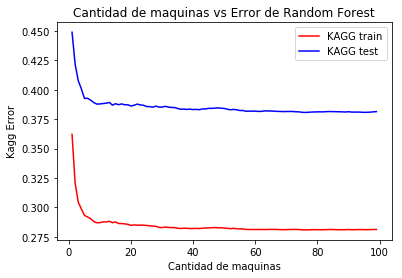

MIN KAGG TRAIN: 0.281021 , Cantidad de maquinas: 79
MIN KAGG TEST: 0.380823 , Cantidad de maquinas: 78


In [55]:
Xdf = df.ix[:,['season','holiday','workingday','weather','temp','atemp','humidity','windspeed','hour','cday','month','year']]
Ydf = np.log(df.ix[:,'count'])

X_train = Xdf[0:ntrain].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_test = Ydf[nval:].values

from sklearn.ensemble import RandomForestRegressor

results_train = []
results_test = []
for n in range(1,100):
    model = RandomForestRegressor(n_estimators=n,min_samples_leaf=3,min_samples_split=23,random_state=0)
    model.fit(X_train, Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    kagg_train = eval_bikemodel(np.exp(Y_pred_train),np.exp(Y_train))
    kagg_test = eval_bikemodel(np.exp(Y_pred_test),np.exp(Y_test))
    results_train.append(kagg_train)
    results_test.append(kagg_test)
    
min_train = results_train.index(min(results_train))+1
min_test = results_test.index(min(results_test))+1

plt.plot(range(1,100), results_train, "r", label="KAGG train")
plt.plot(range(1,100), results_test, "b", label="KAGG test")
plt.xlabel("Cantidad de maquinas")
plt.ylabel("Kagg Error")
plt.title("Cantidad de maquinas vs Error de Random Forest")
plt.legend()
plt.show()

print("MIN KAGG TRAIN: %f , Cantidad de maquinas: %i"%(results_train[min_train], min_train+ 2))
print("MIN KAGG TEST: %f , Cantidad de maquinas: %i"%(results_test[min_test], min_test+ 2))

De esta forma el resultado del test es bastante mayor que en los casos anteriores, menor al de cross validation de árboles de regresión pero mayor que la svm. Utilizar los mismos hiper parámetros disminuyó el error del test pero quedaría hacer el mismo proceso que se hizo para cross validation que fue variar los parámetros para ver como se adaptan para los nuevos modelos. Random forest es una técnica diferente por lo que no se ajusta de la misma forma a los parámetros.

Como resultado del experimento, SVM no lineal tiene por lejos mejores resultados.